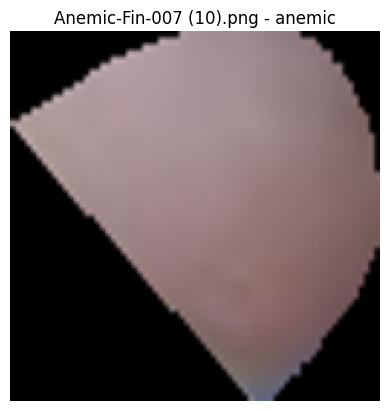

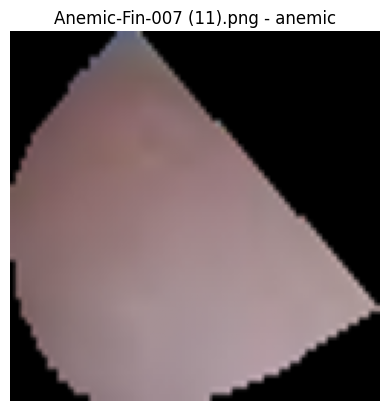

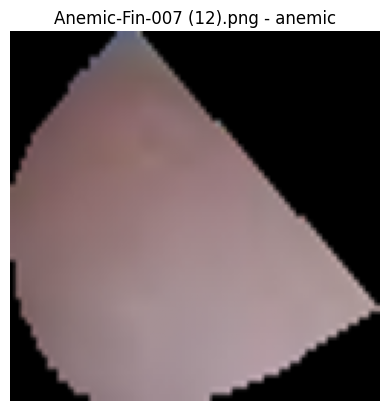

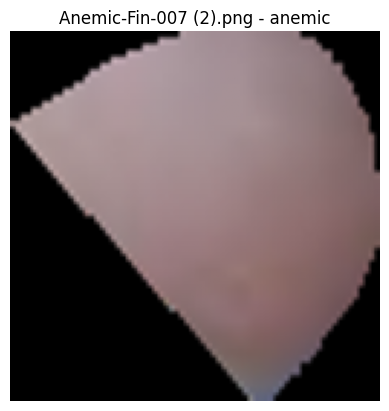

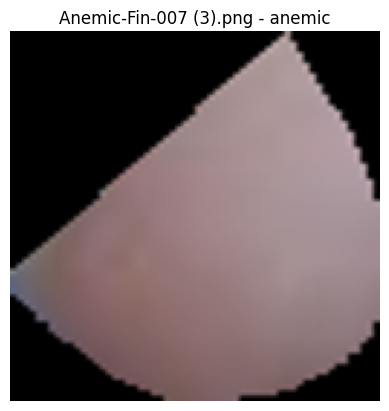

In [5]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = (128, 128)
DATASET_PATH = 'Fingernails'  # change this as per your location

# Helper to determine label
def get_label(filename):
    name = filename.lower()
    if "anemic" in name:
        return "anemic"
    elif "non" in name or "normal" in name:
        return "non-anemic"
    else:
        return "unknown"

# Load and preprocess images
images = []
labels = []
file_names = []

for file in os.listdir(DATASET_PATH):
    if file.endswith(('.png', '.jpg', '.jpeg')):
        try:
            path = os.path.join(DATASET_PATH, file)
            img = Image.open(path).convert('RGB')
            img = img.resize(IMG_SIZE)
            img_array = np.array(img) / 255.0  # Normalize
            label = get_label(file)

            if label != "unknown":
                images.append(img_array)
                labels.append(label)
                file_names.append(file)
        except Exception as e:
            print(f"Error with {file}: {e}")

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Display a few samples
for i in range(5):
    plt.imshow(images[i])
    plt.title(f"{file_names[i]} - {labels[i]}")
    plt.axis('off')
    plt.show()

In [6]:
import cv2
import numpy as np
from PIL import Image

def detect_nail_polish(image_array, sat_thresh=0.5, color_ratio_thresh=0.25):
    """
    Detect if nail polish is present in the image.
    Uses HSV color thresholding.
    """
    # Convert to OpenCV format
    image_bgr = (image_array * 255).astype(np.uint8)
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_RGB2HSV)

    # Normalize HSV values
    h, s, v = cv2.split(image_hsv)
    s = s / 255.0
    v = v / 255.0

    # Count highly saturated & bright pixels
    high_sat = (s > sat_thresh) & (v > 0.3)
    ratio = np.sum(high_sat) / high_sat.size

    return ratio > color_ratio_thresh  # Returns True if polish is likely present

# Example: Apply detection to your images
polish_flags = []

for img in images:
    has_polish = detect_nail_polish(img)
    polish_flags.append(has_polish)

# Count how many have polish
print("Detected nail polish in:", sum(polish_flags), "images")

# Optional: Show a few samples with detected polish
import matplotlib.pyplot as plt
for i in range(5):
    if polish_flags[i]:
        plt.imshow(images[i])
        plt.title(f"Nail Polish Detected - {file_names[i]}")
        plt.axis('off')
        plt.show()

Detected nail polish in: 248 images


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np

# Reshape features for CNN input
X = X_resampled.reshape(-1, 4, 4, 1280)  # Based on MobileNetV2 pooling output
y = y_resampled

# Define CNN Model
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(4, 4, 1280)),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 5-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_index, test_index in kf.split(X, y):
    print(f"\n📁 Fold {fold}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_model()
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

    y_pred = (model.predict(X_test) > 0.5).astype(int)

    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    fold += 1

NameError: name 'X_resampled' is not defined

In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

# Pre-trained model for feature extraction
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3), pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Normalize and preprocess images
preprocessed_imgs = preprocess_input(images * 255.0)
features = feature_extractor.predict(preprocessed_imgs)

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features.reshape(len(features), -1), encoded_labels)

ModuleNotFoundError: No module named 'imblearn'

In [9]:
pip install imbalanced-learn

   ---------------------------------------- 0.0/238.4 kB ? eta -:--:--
   -------- ------------------------------- 51.2/238.4 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 238.4/238.4 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

# Load MobileNetV2 (pretrained, no top layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3), pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Normalize and preprocess images
preprocessed_imgs = preprocess_input(images * 255.0)
features = feature_extractor.predict(preprocessed_imgs)

# Encode labels (Anemic / Not Anemic)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Apply SMOTE to the extracted features
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, encoded_labels)

# Check class distribution
from collections import Counter
print("After SMOTE:", Counter(y_resampled))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 39s 277ms/step
After SMOTE: Counter({0: 2635, 1: 2635})


In [13]:
def build_model():
    model = models.Sequential([
        layers.Input(shape=(1280,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np

X = X_resampled  # shape: (samples, 1280)
y = y_resampled

def build_model():
    model = models.Sequential([
        layers.Input(shape=(1280,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_index, test_index in kf.split(X, y):
    print(f"\n📁 Fold {fold}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_model()
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

    y_pred = (model.predict(X_test) > 0.5).astype(int)

    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    fold += 1


📁 Fold 1
Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5635 - loss: 0.7519
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6581 - loss: 0.6089
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6948 - loss: 0.5609
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7504 - loss: 0.4808
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7882 - loss: 0.4381
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8117 - loss: 0.3843
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8428 - loss: 0.3480
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8580 - loss: 0.3092
Epoch 9/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8758 - loss: 0.2883
Epoch 10/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8855 - loss: 0.2612
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

      anemic       0.90      0.84  

In [16]:
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

def predict_anemia(image_path, model, feature_extractor, label_encoder):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype("float32") / 255.0
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)  # Shape: (1, 128, 128, 3)

    # Extract features using MobileNetV2
    features = feature_extractor.predict(img)

    # Predict with trained model
    prediction = model.predict(features)
    predicted_class = int(prediction[0] > 0.5)

    # Decode label
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    return predicted_label

In [17]:
# Save the final trained model
model.save("anemia_detection_model.h5")
print("✅ Model saved as anemia_detection_model.h5")

✅ Model saved as anemia_detection_model.h5


In [18]:
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

def predict_anemia(image_path, model, feature_extractor, label_encoder):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype("float32") / 255.0
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)  # Shape: (1, 128, 128, 3)

    # Extract features using MobileNetV2
    features = feature_extractor.predict(img)

    # Predict with trained model
    prediction = model.predict(features)
    predicted_class = int(prediction[0] > 0.5)

    # Decode label
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    return predicted_label

In [20]:
def detect_nail_polish(img):
    """
    Detect nail polish using color saturation and brightness thresholds.
    Returns True if polish is detected.
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Mask for high saturation (common in nail polish)
    high_saturation = cv2.inRange(hsv, (0, 70, 50), (180, 255, 255))

    # Count percentage of high saturation pixels
    percent_color = np.sum(high_saturation > 0) / (img.shape[0] * img.shape[1]) * 100

    return percent_color > 10  # If >10% of area is highly saturated, assume polish present

def predict_anemia_with_polish_check(image_path, model, feature_extractor, label_encoder):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Check for nail polish
    if detect_nail_polish(img_rgb):
        return "❌ Error: Nail Polish Detected"

    # Continue if no polish
    img_preprocessed = preprocess_input(img_rgb.astype("float32") / 255.0)
    img_preprocessed = np.expand_dims(img_preprocessed, axis=0)

    # Extract features and predict
    features = feature_extractor.predict(img_preprocessed)
    prediction = model.predict(features)
    predicted_class = int(prediction[0] > 0.5)

    return label_encoder.inverse_transform([predicted_class])[0]